In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import os
import mplhep as hep
hep.style.use("ATLAS")
# sys.path.append("../DataProcessing")
sys.path.append("../Plotting")
import Utils as ut

import ReweightMCDataLoading as rmc
aleph_mc_name = "ArchivedMC"
new_mc_name = "Sherpa"
theory_variations = [
    ["Pythia8", "/pscratch/sd/b/badea/aleph/unfold-ee-logtau/ReweightMC/results/training-200471c7/39912440_0/model_weights_b7634c53/Reweight_Step2.reweight.npy"],
    ["Herwig", "/pscratch/sd/b/badea/aleph/unfold-ee-logtau/ReweightMC/results/training-200471c7/39912440_1/model_weights_cc44b19d/Reweight_Step2.reweight.npy"],
    ["Sherpa", "/pscratch/sd/b/badea/aleph/unfold-ee-logtau/ReweightMC/results/training-200471c7/39912440_2/model_weights_afd3a072/Reweight_Step2.reweight.npy"]
]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


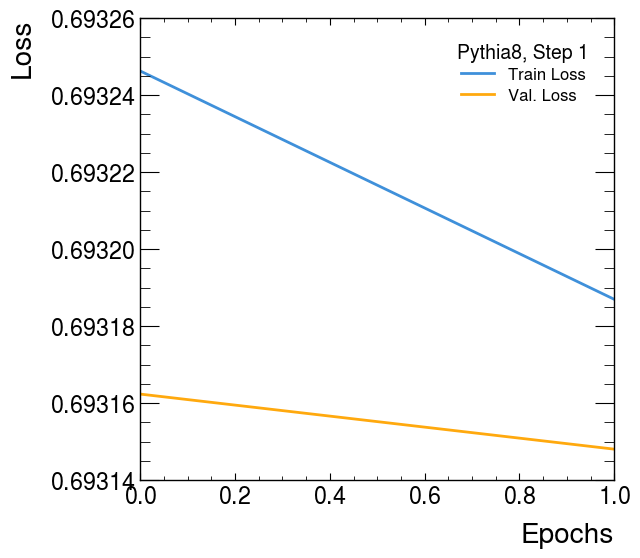

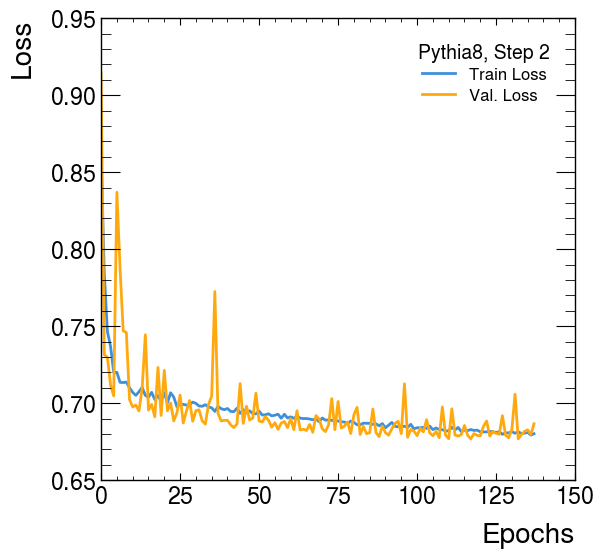

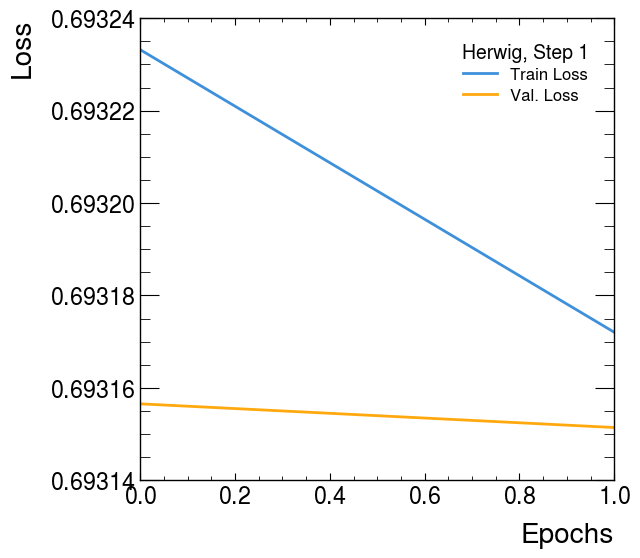

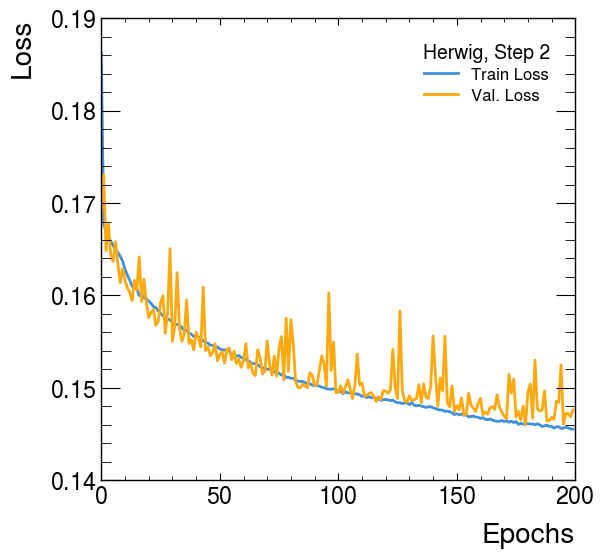

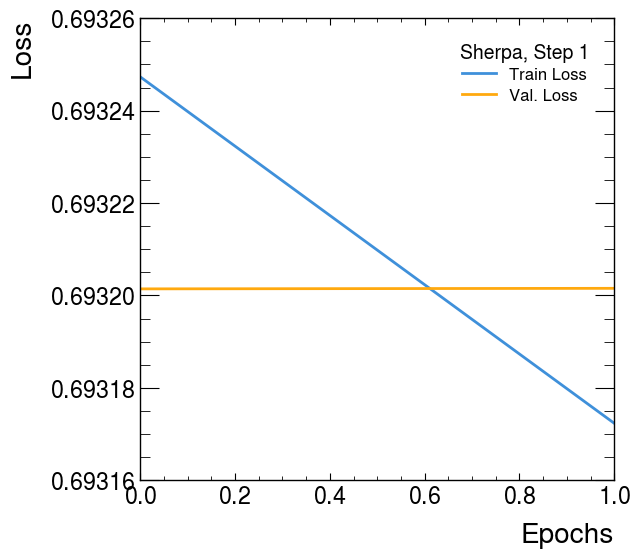

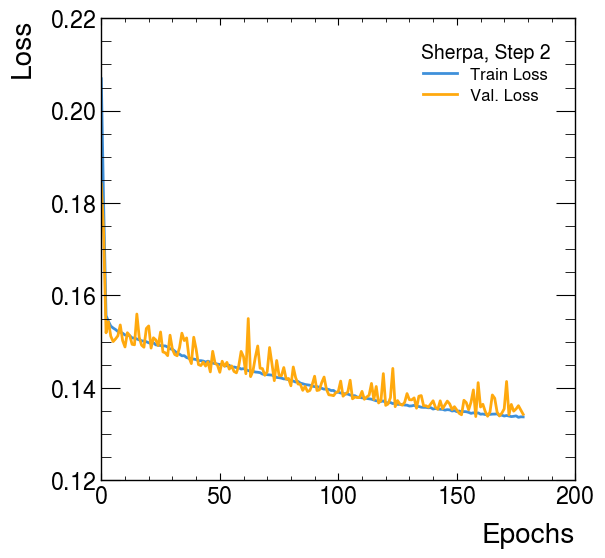

In [87]:
# plot the loss curves. Immediately shows which MC reweighting converged
for name, theory_variation_path in theory_variations:
    for i in [1, 2]:
        inFileName = os.path.join(os.path.dirname(theory_variation_path), f"Reweight_Step{i}.reweight.npy")

        # plot the loss
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        with open(inFileName.replace(".reweight.npy", ".pkl"), 'rb') as f:
            temp = pickle.load(f)
        train_loss = temp['loss']
        val_loss = temp['val_loss']
        epochs = list(range(0, len(train_loss)))
        ax.plot(epochs, train_loss, label=f'Train Loss')
        ax.plot(epochs, val_loss, label=f'Val. Loss')

        ax.legend(fontsize=12, ncol=1, loc="upper right", title=f"{name}, Step {i}")
        fig.savefig(f"plots/{name}_loss_step{i}.pdf", bbox_inches='tight')
        plt.show()


In [88]:
# # load mc data
# mc_names = ["ArchivedMC", "Pythia8", "Herwig", "Sherpa"]
# mc_data = {}
# for mc_name in mc_names:
#     print(f"Loading {mc_name} ...")
#     mc_data[mc_name] = {}
#     # load the mc data
#     mc_data[mc_name]["kinem"] = rmc.loadDataParticles(
#         filePath = rmc.mc_paths[mc_name]["path"],
#         treeName = rmc.mc_paths[mc_name]["tree"],
#         branches = rmc.mc_paths[mc_name]["branches"],
#         maxNPart = 65
#     )
#     print(f"{mc_name} shape: {mc_data[mc_name]['kinem'].shape}")
#     # convert to eta, phi, p_mag
#     mc_data[mc_name]['kinem'] = rmc.convert_PxPyPz_to_EtaPhiPmag(mc_data[mc_name]['kinem'])
#     print(f"{mc_name} converted shape: {mc_data[mc_name]['kinem'].shape}")

#     # load thrust
#     mc_data[mc_name]["thrust"] = rmc.loadData(
#         filePath = rmc.mc_paths[mc_name]["path"], # thrust_path
#         treeName = rmc.mc_paths[mc_name]["tree"], 
#         branches = ["Thrust"], 
#     )
#     mc_data[mc_name]["thrust"] = np.log(1-mc_data[mc_name]["thrust"]).flatten()
#     print(f"{mc_name} thrust shape: {mc_data[mc_name]['thrust'].shape}")

In [89]:
# load particle level distributions
aleph_mc = rmc.loadDataParticles(
        filePath = rmc.mc_paths[aleph_mc_name]["path"],
        treeName = rmc.mc_paths[aleph_mc_name]["tree"],
        branches = rmc.mc_paths[aleph_mc_name]["branches"],
        maxNPart = 80
    )
print(aleph_mc.shape)

new_mc = rmc.loadDataParticles(
    filePath = rmc.mc_paths[new_mc_name]["path"], 
    treeName = rmc.mc_paths[new_mc_name]["tree"],
    branches = rmc.mc_paths[new_mc_name]["branches"],
    maxNPart = 80
)
print(new_mc.shape)

(973769, 80, 3)
(5000000, 80, 3)


In [90]:
aleph_mc = rmc.convert_PxPyPz_to_EtaPhiPmag(aleph_mc)
new_mc = rmc.convert_PxPyPz_to_EtaPhiPmag(new_mc)

In [91]:
# load thrust distributions
aleph_mc_thrust = rmc.loadData(
    filePath = rmc.mc_paths[aleph_mc_name]["path"], # thrust_path
    treeName = rmc.mc_paths[aleph_mc_name]["tree"], 
    branches = ["Thrust"], 
)
print(aleph_mc_thrust.shape)

new_mc_thrust = rmc.loadData(
    filePath = rmc.mc_paths[new_mc_name]["path"], #.replace(".root", "_thrust.root"), 
    treeName = rmc.mc_paths[new_mc_name]["tree"],
    branches = ["Thrust"],
)
print(new_mc_thrust.shape)

# convert to log(1-T)
aleph_mc_thrust = np.log(1-aleph_mc_thrust).flatten()
new_mc_thrust = np.log(1-new_mc_thrust).flatten()

(973769, 1)
(5000000, 1)


In [92]:
sys.path.append("../")
import dataloader
import json

with open("../training_conf.json") as f:
      training_conf = json.load(f)

# load thrust distributions
reco_data, reco_mc, gen_mc, pass_reco, pass_gen = dataloader.DataLoader(training_conf)

(1365440,) 1326338
(771597,) 751853


/pscratch/sd/b/badea/aleph/unfold-ee-logtau/ReweightMC/results/training-200471c7/39912440_2/model_weights_afd3a072/Reweight_Step2.reweight.npy
1 (973769,) (973769, 80, 1)


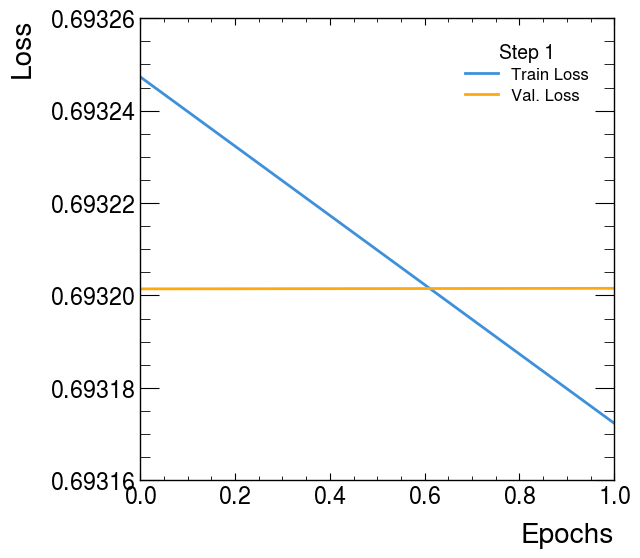

/pscratch/sd/b/badea/aleph/unfold-ee-logtau/ReweightMC/results/training-200471c7/39912440_2/model_weights_afd3a072/Reweight_Step2.reweight.npy
2 (973769,) (973769, 80, 1)


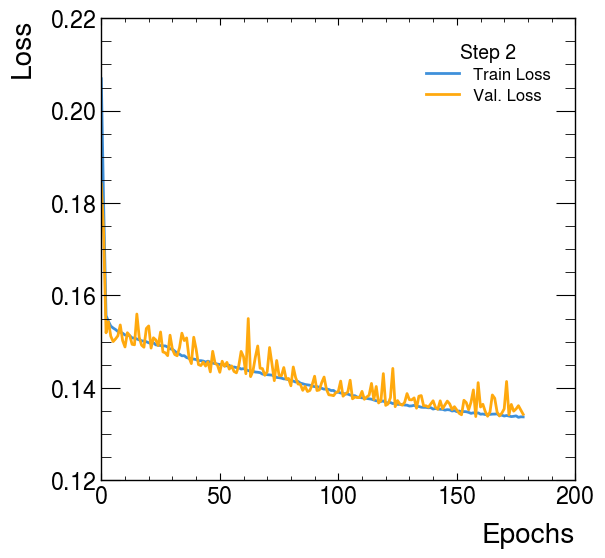

In [93]:
reweight = {}

for i in [1, 2]:
    # inFileName = f"/pscratch/sd/b/badea/aleph/unfold-ee-logtau/ReweightMC/results/{training_dir}/Reweight_Step{i}.reweight.npy"
    theory_variation_path = [i[1] for i in theory_variations if i[0] == new_mc_name][0]
    print(theory_variation_path)
    inFileName = os.path.join(os.path.dirname(theory_variation_path), f"Reweight_Step{i}.reweight.npy")
    temp = np.load(inFileName)
    reweight[f"Step{i}"] = temp
    temp = np.tile(temp[:, np.newaxis, np.newaxis], (1, aleph_mc.shape[1], 1))
    reweight[f"Step{i}_tile"] = temp
    print(i, reweight[f"Step{i}"].shape, reweight[f"Step{i}_tile"].shape)

    # plot the loss
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    with open(inFileName.replace(".reweight.npy", ".pkl"), 'rb') as f:
        temp = pickle.load(f)
    train_loss = temp['loss']
    val_loss = temp['val_loss']
    epochs = list(range(0, len(train_loss)))
    ax.plot(epochs, train_loss, label=f'Train Loss')
    ax.plot(epochs, val_loss, label=f'Val. Loss')

    ax.legend(fontsize=12, ncol=1, loc="upper right", title=f"Step {i}")
    fig.savefig(f"plots/{new_mc_name}_loss_step{i}.pdf", bbox_inches='tight')
    plt.show()


In [94]:
conf = {
    "pmag" : {
        "bins" : np.linspace(0, 50, 51),
        "ax1_ylim" : [10**-5, 10**0],
        "ax2_ylim" : [0.01, 1.99],
        "ax2_xlabel" : r"$|p|$ [GeV]",
        "legend_loc" : "upper right",
        "legend_bbox" : (0.95, 1),
    },
    "eta" : {
        "bins" : np.linspace(-5, 5, 51),
        "ax1_ylim" : [10**-4, 10**0],
        "ax2_ylim" : [0.01, 1.99],
        "ax2_xlabel" : r"$\eta$",
        "legend_loc" : "center",
        "legend_bbox" : (0.5, 0.2),
    },
    "phi" : {
        "bins" : np.linspace(-4, 4, 51),
        "ax1_ylim" : [10**-2, 10**0],
        "ax2_ylim" : [0.01, 1.99],
        "ax2_xlabel" : r"$\phi$",
        "legend_loc" : "upper right",
        "legend_bbox" : (0.99, 1),
    },
    "logtau" : {
        "bins" : np.linspace(-8, np.log(0.5), 51),
        "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/dlog(1-T)",
        "ax1_yscale" : "log",
        "ax1_ylim" : [0.2*10**-5, 10**0],
        "ax2_ylim" : [0.01, 2.49],
        "ax2_xlabel" : r"$\log(\tau$)",
        "legend_loc" : "upper left",
        "legend_bbox" : (0.35, 0.4),
    }
}

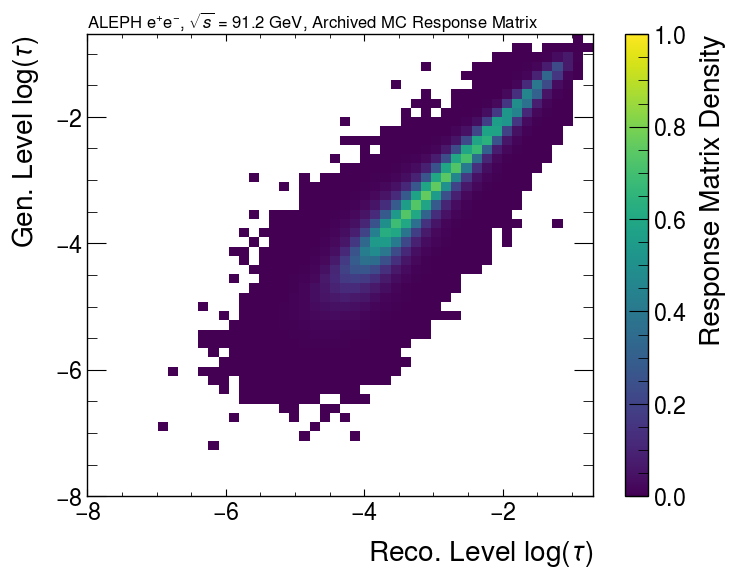

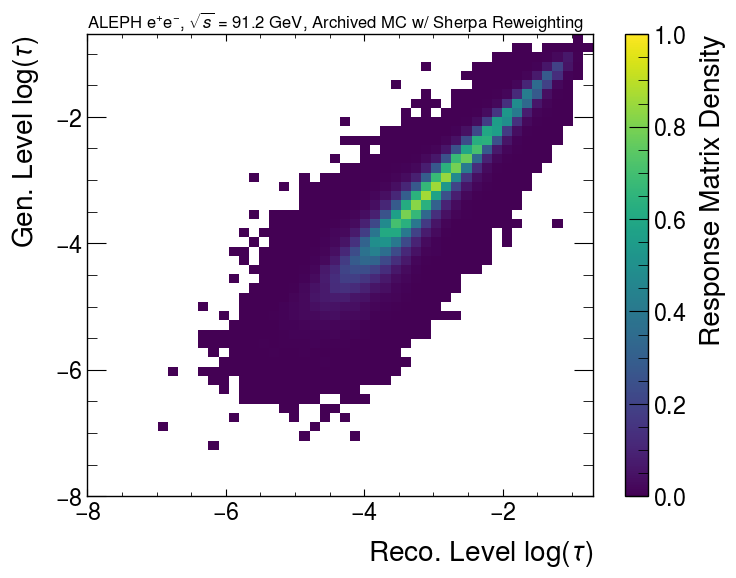

/tmp/ipykernel_2207954/2827564507.py:56: RuntimeWarning: invalid value encountered in divide
  plt.imshow(response2/response1, vmin=0, vmax=5, origin='lower',


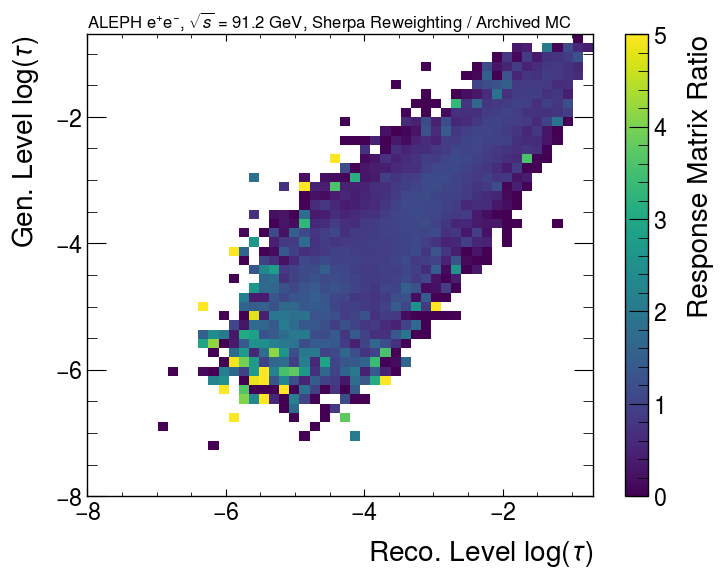

In [95]:
header = r"ALEPH e$^{+}$e$^{-}$, $\sqrt{s}$ = 91.2 GeV"
xlabel = r"Reco. Level $\log(\tau)$"
ylabel = r"Gen. Level $\log(\tau)$"
zlabel = "Response Matrix Density"
density=True
ticks = [-8, -6, -4, -2]

response1 = np.histogram2d(reco_mc[pass_reco].flatten(), gen_mc[pass_reco].flatten(), bins=(conf["logtau"]["bins"], conf["logtau"]["bins"]), density=density)[0]
# response1 /= (response1.sum(axis=0) + 10**-50)
response1_nan = response1.copy()
response1_nan[response1_nan == 0] = np.nan # use this because nan's appear as empty in the plot
plt.imshow(
    response1_nan,
    vmin=0,
    vmax=1,
    origin='lower',
    extent=[
        conf["logtau"]["bins"][0], conf["logtau"]["bins"][-1],
        conf["logtau"]["bins"][0], conf["logtau"]["bins"][-1]
    ],
    aspect='auto',
    cmap='viridis'  # 'viridis' colormap: white/yellow for low, blue/purple for high
)
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(header + ", Archived MC Response Matrix", loc='left', pad=5, fontsize=12)
cbar = plt.colorbar()
cbar.set_label(zlabel)
plt.savefig(f"plots/{new_mc_name}_ResponseMatrix.pdf", bbox_inches='tight')
plt.show()

response2 = np.histogram2d(reco_mc[pass_reco].flatten(), gen_mc[pass_reco].flatten(), bins=(conf["logtau"]["bins"], conf["logtau"]["bins"]), weights=reweight[f"Step2"][pass_reco], density=density)[0]
# response2 /= (response2.sum(axis=0) + 10**-50)
response2_nan = response2.copy()
response2_nan[response2_nan == 0] = np.nan # use this because nan's appear as empty in the plot
plt.imshow(response2_nan, vmin=0, vmax=1, origin='lower',
    extent=[
        conf["logtau"]["bins"][0], conf["logtau"]["bins"][-1],
        conf["logtau"]["bins"][0], conf["logtau"]["bins"][-1]
    ],
    aspect='auto'
)
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(header + f", Archived MC w/ {new_mc_name} Reweighting", loc='left', pad=5, fontsize=12)
cbar = plt.colorbar()
cbar.set_label(zlabel)
plt.savefig(f"plots/{new_mc_name}_ResponseMatrixReweighted.pdf", bbox_inches='tight')
plt.show()

# plt.imshow(response2/response1, vmin = 0, vmax = 2, origin='lower')
plt.imshow(response2/response1, vmin=0, vmax=5, origin='lower',
    extent=[
        conf["logtau"]["bins"][0], conf["logtau"]["bins"][-1],
        conf["logtau"]["bins"][0], conf["logtau"]["bins"][-1]
    ],
    aspect='auto'
)
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(header + f", {new_mc_name} Reweighting / Archived MC", loc='left', pad=5, fontsize=12)
cbar = plt.colorbar()
cbar.set_label("Response Matrix Ratio", labelpad=15)
plt.savefig(f"plots/{new_mc_name}_ResponseMatrixRatio.pdf", bbox_inches='tight')
plt.show()

In [96]:
plots = {}

branch = "logtau"
plots[branch] = {}
plots[branch][f"h_aleph_mc"] = ut.calc_hist(aleph_mc_thrust, bins=conf[branch]["bins"], density=True)
plots[branch][f"h_aleph_mc_rw_step1"] = ut.calc_hist(aleph_mc_thrust, bins=conf[branch]["bins"], density=True, weights=reweight["Step1"])
plots[branch][f"h_aleph_mc_rw_step2"] = ut.calc_hist(aleph_mc_thrust, bins=conf[branch]["bins"], density=True, weights=reweight[f"Step2"])
plots[branch][f"h_new_mc"] = ut.calc_hist(new_mc_thrust, bins=conf[branch]["bins"], density=True)

branches = ["eta", "phi", "pmag"]
for iB, branch in enumerate(branches): #rmc.mc_paths[new_mc_name]["branches"]):
    plots[branch] = {}
    
    # aleph mc
    mask = ~np.isnan(aleph_mc[:,:,iB].flatten()) # != -999
    plots[branch][f"h_aleph_mc"] = ut.calc_hist(aleph_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True)
    plots[branch][f"h_aleph_mc_rw_step1"] = ut.calc_hist(aleph_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True, weights=reweight["Step1_tile"].flatten()[mask])
    plots[branch][f"h_aleph_mc_rw_step2"] = ut.calc_hist(aleph_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True, weights=reweight[f"Step2_tile"].flatten()[mask])
    # new mc
    mask = ~np.isnan(new_mc[:,:,iB].flatten()) # new_mc[:,:,iB].flatten() != -999
    plots[branch][f"h_new_mc"] = ut.calc_hist(new_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True)

/global/u1/b/badea/aleph/unfold-ee-logtau/ReweightMC/../Plotting/Utils.py:172: RuntimeWarning: invalid value encountered in divide
  ratio = A / B
/global/u1/b/badea/aleph/unfold-ee-logtau/ReweightMC/../Plotting/Utils.py:172: RuntimeWarning: divide by zero encountered in divide
  ratio = A / B


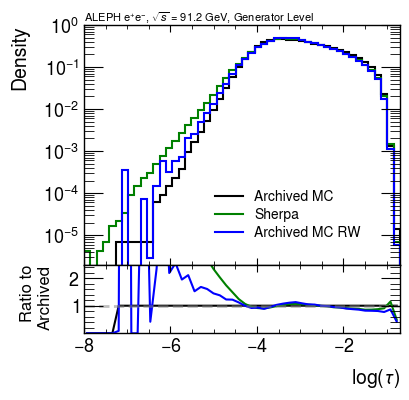

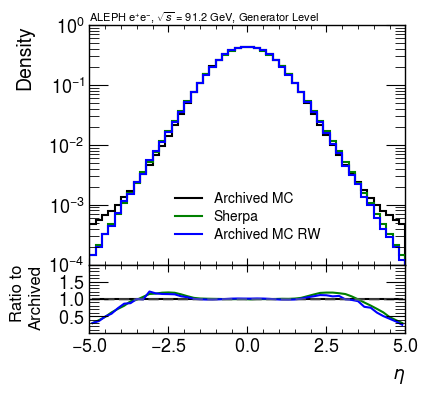

/global/u1/b/badea/aleph/unfold-ee-logtau/ReweightMC/../Plotting/Utils.py:172: RuntimeWarning: invalid value encountered in divide
  ratio = A / B


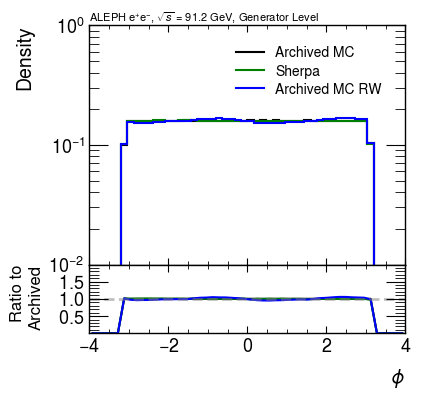

/global/u1/b/badea/aleph/unfold-ee-logtau/ReweightMC/../Plotting/Utils.py:172: RuntimeWarning: invalid value encountered in divide
  ratio = A / B


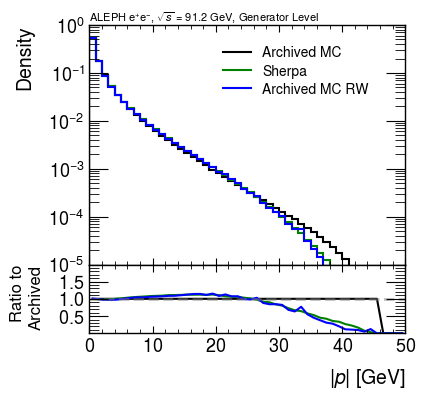

In [97]:
for key, val in plots.items():

    # style
    style = {
        "legend_loc" : conf[key]["legend_loc"],
        "legend_bbox" : conf[key]["legend_bbox"],
        "legend_ncol" : 1,
        "legend_fontsize" : 10,
        "ax1_ylabel" : "Density",
        "ax1_yscale" : "log",
        "ax2_xlabel" : conf[key]["ax2_xlabel"], #f"{key}" + (" [GeV]" if key in ["p"] else ""),
        "ax2_xscale" : "linear",
        "ax2_ylabel" : f'Ratio to\nArchived',
        "ax1_ylim" : conf[key]["ax1_ylim"],
        "bins" : conf[key]["bins"],
        "ax2_ylim" : conf[key]["ax2_ylim"],
    }

    # plot
    inPlots = {}
    inPlots["tgenBefore"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_aleph_mc"][0], "color": "black", "label": "Archived MC", "ls":"-"}
    inPlots["new_mc"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_new_mc"][0], "color": "green", "label": new_mc_name, "ls":"-"}
    # inPlots["tgenBefore_rw_step1"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_aleph_mc_rw_step1"][0], "color": "red", "label": "Reweight Step 1", "ls":"-"}
    inPlots["tgenBefore_rw_step2"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_aleph_mc_rw_step2"][0], "color": "blue", "label": "Archived MC RW", "ls":"-"}
    
    # ratio denominator using the total error
    ratio_denom = [val["h_aleph_mc"]]

    header = r"ALEPH e$^{+}$e$^{-}$, $\sqrt{s}$ = 91.2 GeV, Generator Level"
    fig, (ax1, ax2) = ut.plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10, header=header)
    plt.show()
    fig.savefig(f"plots/{new_mc_name}_{key}_reweight.pdf", bbox_inches='tight')
    plt.close()